## model

In [1]:
import tensorflow as tf
import numpy as np
from math import sqrt
import time

import logging
import math
import os
import random
import sys
import shutil
import time
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
from tensorflow.python.util import compat
from sklearn.model_selection import train_test_split

def task_specific_attention(inputs, output_size,
                            initializer=tf.contrib.layers.xavier_initializer(),
                            activation_fn=tf.tanh, scope=None):

    assert len(inputs.get_shape()) == 3 and inputs.get_shape()[-1].value is not None

    with tf.variable_scope(scope or 'attention') as scope:
        attention_context_vector = tf.get_variable(name='attention_context_vector',
                                                   shape=[output_size],
                                                   initializer=initializer,
                                                   dtype=tf.float32)
        input_projection = tf.contrib.layers.fully_connected(inputs, output_size,
                                                  activation_fn=activation_fn)

        attention_weights = tf.nn.softmax(tf.reduce_sum(tf.multiply(input_projection, attention_context_vector), axis=2))
        attention_weights = tf.expand_dims(attention_weights, -1)#在最后一列加一个1，扩充一列
        weighted_projection = tf.multiply(attention_weights, inputs)
        outputs = tf.reduce_sum(weighted_projection, axis=1)
        return outputs,attention_weights


    
class Network(object):
    def __init__(self,
             
                 n_hidden = 64,
                 dropout_keep_prob=0.8
                 ):
   
        #n_hidden = 1024 # hidden layer num of features
        self.x = tf.placeholder("float", [None, None, alphabet_size], name="inputs")
        self.y = tf.placeholder(tf.int64, [None, ], name="labels")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
        #n_hidden = 64 # hidden layer num of features
        self.network = tl.layers.InputLayer(self.x, name='input_layer')
        self.network = tl.layers.BiDynamicRNNLayer(self.network,
            cell_fn         = tf.contrib.rnn.BasicLSTMCell,
            n_hidden        = n_hidden,
            dropout         = dropout_keep_prob,
            sequence_length = tl.layers.retrieve_seq_length_op(self.x),
            return_seq_2d   = False,
            return_last     = False,
            n_layer         = 3,
            name            = 'dynamic_rnn1')
        character_encoder_output = self.network.outputs

            
        with tf.variable_scope('attention') as scope:
            character_level_output,attention_weights = task_specific_attention(
                character_encoder_output, 250, scope=scope)

        with tf.variable_scope('classifier'):
            self.logits = tf.contrib.layers.fully_connected(
                character_level_output, 2, activation_fn=None)

                                     
        #=========
        self.attention_weights=attention_weights
       
   
        #########
        self.network.outputs_op = tf.argmax(self.logits, axis=-1)
        

        self.loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y,logits=self.logits)
        self.loss = tf.reduce_mean(self.loss)
            
  

        #self.loss      = tl.cost.cross_entropy(self.logits, self.y, 'xentropy')


        self.accuracy  = tf.reduce_mean(tf.cast(tf.nn.in_top_k(self.logits, self.y, 1), tf.float32))


## data

In [2]:
one_hot_list=[]
alpha2id_dict={}
alphabet=" abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
alphabet_size = len(alphabet)
one_hot_list = np.eye(alphabet_size, dtype='int64')
for i, c in enumerate(alphabet):
    alpha2id_dict[c] = i + 1
#print(one_hot_list)
#print(alpha2id_dict)
sqe_limit=256## max length of sequence
#dataset_name="TC"  ##toxic comment
#dataset_name="ISIS" ## isis fans
#dataset_name="Nazi"# nazi 
#dataset_name="Mixture" #Mixture
#dataset_name="Word" #wordList
#dataset_name="Chat"
dataset_name="test"
def load_dataset(test_size=0.2):
    """加载样本并取test_size的比例做测试集
    Args:
        files: 样本文件目录集合
            样本文件是包含了样本特征向量与标签的npy文件
        test_size: float
            0.0到1.0之间，代表数据集中有多少比例抽做测试集
    Returns:
        X_train, y_train: 训练集特征列表和标签列表
        X_test, y_test: 测试集特征列表和标签列表0
    """

    x = []
    y = []

    #=====
    for label in ["good", "bad"]:
        samples = []
        show=[]
        #inp = "data/" + label + "Lines.txt"
        inp = "data/"+dataset_name + label + "Line.txt" 
        f = open(inp,encoding="utf-8")
        for line in f:
            #words = list(line.strip())
            line=line.lower()
            #print(line)
            words = list(line)
            #print(words)
            #if(label=="bad"):
            #    print(words)
            text_sequence = []# every line
           
            #for word in words:#every character
            for i,word in enumerate(words):#every character
                try:
                    if(i<sqe_limit):
                        #print(word)
                        #print("word",word,one_hot_list[alpha2id_dict[word]])
                        text_sequence.append(one_hot_list[alpha2id_dict[word]])
                        #print("ok")
                    else:
                        #print("cut")
                        break
                except:
                    #print("error")
                    #print("error",words,"/",word)
                    continue
            sqe_num=len(text_sequence)
            #print("line",line,"text_sequence",sqe_num)
            if(sqe_num==0):
                break
            if(sqe_num<sqe_limit):
                #print("shape",np.array(text_sequence).shape)
                text_sequence=np.pad(np.array(text_sequence), ((0,sqe_limit-sqe_num),(0,0)), 'constant')
                
            samples.append(text_sequence)
            
        if label == "good":
            labels = np.zeros(len(samples))
            #labels = np.zeros(len(samples),dtype="int64")
            #labels = np.ones(len(samples))
        elif label == "bad":
            labels = np.ones(len(samples))
            #labels = np.zeros(len(samples))-1
            #labels = np.ones(len(samples),dtype="int64")
        if x == [] or y == [] :
            x = samples
            y = labels
            
        else:
            x = np.append(x, samples, axis=0)
            y = np.append(y, labels, axis=0)
          
        
        f.close()
    
   
      
   
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=11)
    return x_train, y_train, x_test, y_test

#def getTrainBatch(x_train,y_train, batch_num=0,batch_size=128,no_of_classes=2):
def getTrainBatch(x_train,y_train, batch_num=0,batch_size=128):
    #将data分成batch，并将字符转化为one-hot编码
    data_size = len(x_train)
    start_index = batch_num * batch_size
    end_index = data_size if batch_size == 0 else min((batch_num + 1) *batch_size, data_size)
     #获取第batch_num批数据（根据开始和结束索引）
    batch_x = x_train[start_index:end_index]
    batch_y = y_train[start_index:end_index]
    #将单词转化为索引存储在batch_indices中
    #batch_y=np.reshape(batch_y,[-1,1])
    return batch_x,batch_y



x_train,y_train,x_test,y_test=load_dataset()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:83: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


## train

In [3]:
import datetime
import time
import numpy as np
import tensorflow as tf
import sys
import os
#import config
#from data_utils import Data
#from char_cnn import CharConvNet

learning_rate = 0.001

alphabet=" abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
alphabet_size = len(alphabet)

#batch_size=128
batch_size=5

#no_of_classes = 2
#--


#--
dropout_keep_prob=0.9
base_rate = 1e-2
#momentum = 0.9


epoches = 100
#evaluate_every = 50
#checkpoint_every = 100

if __name__ == '__main__':
    print ('start...')
    #execfile("config.py")
    #print config.model.th
    print ('end...')
    print ("Loading data ....")
 
    
    

    num_batches_per_epoch = int(len(x_train) / batch_size) + 1
    num_batch_dev = len(x_test)
    print ("Loaded")
 
    print ("Training ===>")
    #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(allow_soft_placement = True,
                                      log_device_placement = False)

        sess = tf.Session(config = session_conf)

        with sess.as_default():
            network = Network()

            global_step = tf.Variable(0, trainable=False)
            #optimizer = tf.train.AdamOptimizer(learning_rate)
            optimizer=tf.train.RMSPropOptimizer(learning_rate,decay=0.8,centered=True,use_locking=True)
            #(learning_rate, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
            grads_and_vars = optimizer.compute_gradients(network.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step = global_step)
            
  

           
           
           
           
            saver = tf.train.Saver()

            sess.run(tf.global_variables_initializer())
            
            checkpoint_prefix = "model/biModel"+dataset_name                          
            def train_step(x_batch, y_batch):
                """
                A single training step
                """
                print("x_batch",x_batch.shape,"y_batch",y_batch.shape)
                feed_dict = {
                  network.x: x_batch,
                  network.y: y_batch,
                  network.dropout_keep_prob: dropout_keep_prob
                }
                _, step, loss, accuracy = sess.run(
                    [train_op,
                     global_step,
                     network.loss,
                     network.accuracy],
                    feed_dict)
                
                time_str = datetime.datetime.now().isoformat()
                #print(loss)
                #newloss=np.mean(loss)
                #print(newloss)
                #print(accuracy)
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
 

            def dev_step(x_batch, y_batch, writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  network.x: x_batch,
                  network.y: y_batch,
                  network.dropout_keep_prob: 1.0 # Disable dropout
                }
                step,loss, accuracy = sess.run(
                    [global_step,
                    
                     network.loss,
                     network.accuracy],
                    feed_dict)
                
                print("{}: step {}, loss {:g}, test_acc {:g}".format(time_str, step, loss, accuracy))
            """  
            def getPadding(batch_x):
                max_seq_len = max([len(d) for d in batch_x])
                for i,d in enumerate(batch_x):
                    batch_x[i] =batch_x[i]+ [np.zeros(alphabet_size) for num in range(max_seq_len - len(d))]
                batch_x = list(batch_x) # ValueError: setting an array element with a sequence.
                    #batch_x=batch_x[:l_0]
                return batch_x
            """  
            best_acc=0
            for e in range(epoches):
                print (e)
                #train_data.shuffleData()
                for k in range(num_batches_per_epoch):

                    batch_x, batch_y = getTrainBatch(x_train,y_train,k)
                    
                    ##padding
                    """
                    max_seq_len = max([len(d) for d in batch_x])
                    for i,d in enumerate(batch_x):
                        batch_x[i] =batch_x[i]+ [np.zeros(alphabet_size) for num in range(max_seq_len - len(d))]
                    #batch_x = list(batch_x) # ValueError: setting an array element with a sequence.
                    #batch_x=batch_x[:l_0]
                    """
                    
                    ##train
                    train_step(batch_x, batch_y)
                    print(k,"/",num_batches_per_epoch)
                    current_step = tf.train.global_step(sess, global_step)
                    
                        
                #test acc
                y_test=np.reshape(y_test,[-1,])
                feed_dict = {network.x: x_test, network.y: y_test}
                #correct   = tf.equal(network.network.outputs_op, network.y)
                #accuracy  = tf.reduce_mean(tf.cast(correct,tf.float32),axis=0)
                
                accuracy  = tf.reduce_mean(tf.cast(tf.nn.in_top_k(network.logits, network.y, 1), tf.float32))
                test_acc  = sess.run(accuracy, feed_dict=feed_dict)

                print( "test_acc",test_acc) #softmax acc= 0.8965
                if(test_acc>best_acc):
                    best_acc=test_acc
                    path = saver.save(sess, checkpoint_prefix)
                    print("Saved model checkpoint to {}\n".format(path))        
                path = saver.save(sess, checkpoint_prefix)

start...
end...
Loading data ....
Loaded
Training ===>
  [TL] InputLayer  input_layer: (?, ?, 70)
  [TL] BiDynamicRNNLayer dynamic_rnn1: n_hidden:64 in_dim:3 in_shape:(?, ?, 70) cell_fn:BasicLSTMCell dropout:0.8 n_layer:3
       non specified batch_size, uses a tensor instead.
     n_params : 12
0
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:04:30.779948: step 1, loss 0.693203, acc 0.375
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:04:31.268109: step 2, loss nan, acc nan
1 / 2
test_acc 0.5
Saved model checkpoint to model/biModeltest

1
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:04:35.614671: step 3, loss 0.693147, acc 0.5
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:04:36.124578: step 4, loss nan, acc nan
1 / 2
test_acc 0.0
2
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:04:38.916540: step 5, loss 0.693131, acc 0.5
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:04:39.336012: step 6, loss nan, acc nan
1 / 2
test_acc 0.0
3
x_batch (8, 256, 70) y_batch (

37
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:06:29.909730: step 75, loss 0.679874, acc 0.625
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:06:30.380559: step 76, loss nan, acc nan
1 / 2
test_acc 0.0
38
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:06:33.092535: step 77, loss 0.679281, acc 0.625
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:06:33.563049: step 78, loss nan, acc nan
1 / 2
test_acc 0.0
39
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:06:36.184428: step 79, loss 0.678799, acc 0.625
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:06:36.662789: step 80, loss nan, acc nan
1 / 2
test_acc 0.0
40
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:06:39.275668: step 81, loss 0.678191, acc 0.625
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:06:39.796306: step 82, loss nan, acc nan
1 / 2
test_acc 0.0
41
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:06:42.428047: step 83, loss 0.677698, acc 0.625
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-0

2018-04-07T17:08:30.595628: step 152, loss nan, acc nan
1 / 2
test_acc 0.5
76
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:08:33.307234: step 153, loss 0.550391, acc 0.875
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:08:33.786941: step 154, loss nan, acc nan
1 / 2
test_acc 0.0
77
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:08:36.439246: step 155, loss 0.296075, acc 0.875
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:08:36.908782: step 156, loss nan, acc nan
1 / 2
test_acc 0.0
78
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:08:39.690748: step 157, loss 0.369559, acc 0.875
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:08:40.180337: step 158, loss nan, acc nan
1 / 2
test_acc 0.0
79
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:08:42.902841: step 159, loss 0.295791, acc 0.875
0 / 2
x_batch (0, 256, 70) y_batch (0,)
2018-04-07T17:08:43.393092: step 160, loss nan, acc nan
1 / 2
test_acc 0.0
80
x_batch (8, 256, 70) y_batch (8,)
2018-04-07T17:08:45.978551: 

## test


In [ ]:
#x_train, y_train, x_test, y_test = load_dataset()

print(x_test.shape)
print(y_test.shape)
y_test=np.reshape(y_test,[-1,1])
feed_dict = {network.x: x_test, network.y: y_test}
correct   = tf.equal(network.network.outputs_op, tf.cast(network.y,tf.int64))
accuracy  = tf.reduce_mean(tf.cast(correct, tf.float32))
#test_acc  = sess.run(accuracy, feed_dict=feed_dict)
#print("accurancy",test_acc)   
print( sess.run(accuracy, feed_dict=feed_dict)) #softmax acc= 0.8965    sigoid acc=0.903167

## single prediction

(1, 17, 70)
  [TL] InputLayer  input_layer: (?, ?, 70)
  [TL] BiDynamicRNNLayer dynamic_rnn1: n_hidden:64 in_dim:3 in_shape:(?, ?, 70) cell_fn:BasicLSTMCell dropout:1.0 n_layer:3
       non specified batch_size, uses a tensor instead.
     n_params : 12
INFO:tensorflow:Restoring parameters from model/biModeltest
offensive


D:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


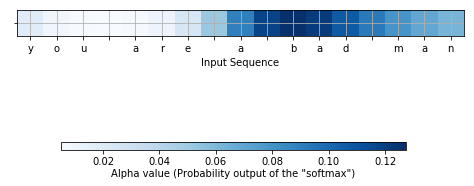

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def draw_attention_map(input_text,attention_weights):
    output_length=1


    attention_weights=attention_weights.reshape((1,attention_weights.shape[1]))
    predicted_text=" "
    input_length=len(input_text)
    text_=list(input_text)
    #Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 3.5))
    ax = f.add_subplot(1, 1, 1)
    attention_map = np.zeros((1, input_length))
    
    Ty, Tx = attention_map.shape




    for t_prime in range(Tx):
        attention_map[0][t_prime] = attention_weights[0][t_prime]


    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=0)

    ax.set_xlabel('Input Sequence')
    #x.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()
    f.show()
#tf.reset_default_graph()
def getSquencetCharvect(line):
    
    
    words = list(line.strip())
    text_sequence = []
    for word in words:
        text_sequence.append(one_hot_list[alpha2id_dict[word]])
    #print(text_sequence)    
    return text_sequence
#input_x=np.array(getSquencetCharvect("they probably in he!l"))#
#input_x=np.array(getSquencetCharvect("pkk claims terrorist attack in revenge for army shelling in northern"))#
#tf.reset_default_graph()
#input_x=np.array(getSquencetCharvect("love"))
#input_x=np.array(getSquencetCharvect("f*cking"))
#input_sent="dude i said i was sorry what you dont give a fuck"
input_sent="you are a bad man"
input_x=np.array(getSquencetCharvect(input_sent))
input_x=np.expand_dims(input_x,0)
print(input_x.shape)

censor_sess=tf.Session()
network = Network( dropout_keep_prob=1.0)  
tf.train.Saver().restore(censor_sess,"model/biModeltest")

feed_dict = {network.x: input_x}
result=censor_sess.run(network.network.outputs_op,feed_dict)

attention_weights=censor_sess.run(network.attention_weights,feed_dict)
#print("attention_weights",attention_weights,np.array(attention_weights).shape)
draw_attention_map(input_sent,attention_weights)
#attention
if(result==[0]):
    print("normal")
else:
    print("offensive")
#print(result)

attention_weights [[[ 0.84622663]
  [ 0.09629885]
  [ 0.01464968]
  [ 0.00401267]
  [ 0.00209272]
  [ 0.00182676]
  [ 0.00241827]
  [ 0.00435293]
  [ 0.00913139]
  [ 0.01899021]]] (1, 10, 1)
normal


D:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


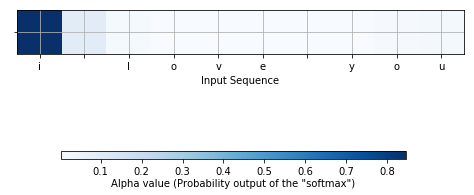

In [6]:

input_sent="i love you"
input_x=np.array(getSquencetCharvect(input_sent))
input_x=np.expand_dims(input_x,0)

feed_dict = {network.x: input_x}
result=censor_sess.run(network.network.outputs_op,feed_dict)

attention_weights=censor_sess.run(network.attention_weights,feed_dict)
print("attention_weights",attention_weights,np.array(attention_weights).shape)
draw_attention_map(input_sent,attention_weights)
#attention
if(result==[0]):
    print("normal")
else:
    print("offensive")
#censor_sess.close()

## profane words detection

In [3]:
def getSquencetCharvect(line):
    words = list(line.strip())
    text_sequence = []
    for word in words:
        text_sequence.append(one_hot_list[alpha2id_dict[word]]) 
    return text_sequence


wordsList=['a$$','@ss','sh!t','$hit','f***','f*cking']
with tf.Session() as censor_sess:
    network = Network( dropout_keep_prob=1.0)  
    tf.train.Saver().restore(censor_sess,"model/biModelWord")
    for word in wordsList:
        input_x=np.array(getSquencetCharvect(word))
        input_x=np.expand_dims(input_x,0)

        feed_dict = {network.x: input_x}
        result=censor_sess.run(network.network.outputs_op,feed_dict)
        if(result==[0]):
            print(word+" is normal")
        else:
            print(word+" is offensive")
        #print(result)

  [TL] InputLayer  input_layer: (?, ?, 70)
  [TL] DynamicRNNLayer dynamic_rnn1: n_hidden:64, in_dim:3 in_shape:(?, ?, 70) cell_fn:BasicLSTMCell dropout:1.0 n_layer:3
       non specified batch_size, uses a tensor instead.
  [TL] DenseLayer  output: 1 identity
INFO:tensorflow:Restoring parameters from model/biModelWord
a$$ is offensive
@ss is offensive
sh!t is offensive
$hit is offensive
f*** is offensive
f*cking is offensive


In [4]:
import numpy as np
loss=[[1,2,3]]
np.mean(loss)

2.0